## Trying first RL-Agents

-----


In [136]:
import numpy as np
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

import src

Target

In [137]:
target = tf.constant([2, 0, 1], dtype=tf.float32)

Defining initial time and state:

In [138]:
from astropy.time import Time
time = Time("2000-01-01 00:00", scale="utc")
walker_name = "test"

walker_position = np.array([2, 0, 0])
walker_velocity = np.array([0, 0, 0])

# walker_position, walker_velocity = src.get_body_state("mars", time).values()

#### Hyperparameters and Environment
------

In [139]:
agent_type = ["PPO", "DQN"][0]
dqn_batch_size = 1024
env_batch_size = 1

fc_layer_params = (32, 32)
learning_rate = 1e-4

train_steps = 500
episodes_per_train_step = 1
episodes_per_eval_step = 1

log_interval = 20

max_episode_length = 365
system_step_size = 1

if agent_type in ["PPO"]:
    max_boost = 2e-5
    replay_buffer_capacity = (
        episodes_per_train_step * 
        env_batch_size * 
        max_episode_length 
        + 10
    )
if agent_type in ["DQN"]:
    max_boost = 2e-5
    replay_buffer_capacity = 10000


In [ ]:
from tf_agents.environments import ActionClipWrapper
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.agents import PPOAgent
from tf_agents.agents import DqnAgent
from tf_agents.networks.q_network import QNetwork
from tf_agents.metrics.tf_metrics import AverageReturnMetric
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.utils.common import function

from keras.optimizers import Adam
from keras import layers


Batched Environment for Training

In [140]:
system = src.SunSystem(["earth"], initial_time=time, add_sun=False)
system.set_smooth = 1e-9
walker = src.Walker(walker_position, walker_velocity, mass=1., name=walker_name)
solver = src.Solver()

In [141]:
# if agent_type in ["PPO"]:
#     class Env(
#         src.env.WalkerSystemEnv,
#         src.env.ContinuousAction,
#         src.env.StateAndDiffObservation
#     ): pass

if agent_type in ["PPO", "DQN"]:
    class Env(
        src.env.WalkerSystemEnv,
        src.env.DiscreteAction,
        src.env.StateAndDiffObservation
    ): pass

env = Env(
    walker, system, solver, target, 
    max_iters=max_episode_length, 
    step_size=system_step_size,
    reward_factor_boost=0,
    max_boost=max_boost,
)

if agent_type in ["PPO"]:
    env = ActionClipWrapper(env)

tf_env = src.env_wrappers.tfpy_env_wrapper(env)

Easily Acessible Eval Env for evaluation:

In [142]:
print('Observation Spec:')
print(tf_env.observation_spec())

print('Action Spec:')
print(tf_env.action_spec())

print('Batch Size:')
print(tf_env.batch_size)

Observation Spec:
{'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='walker-state'), 'diff-to-target': TensorSpec(shape=(3,), dtype=tf.float32, name='target')}
Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int32, name='boost-direction', minimum=array(0), maximum=array(6))
Batch Size:
1


#### Agent and Policies
-----

In [143]:
optimizer = Adam(learning_rate=learning_rate)

obs_specs = tf_env.observation_spec()

pre_layers = {k: layers.Flatten() for k in obs_specs}
pre_combiner = layers.Concatenate(axis=-1)

In [144]:
if agent_type == "PPO":

    actor_net = ActorDistributionNetwork(
        input_tensor_spec=obs_specs,
        output_tensor_spec=tf_env.action_spec(),
        preprocessing_layers=pre_layers,    # Must be of the same type (dict in this case) as `input_tensor_spec`
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params
    )

    value_net = ValueNetwork(
        obs_specs,
        preprocessing_layers=pre_layers,
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params
    )

    tf_agent = PPOAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        actor_net=actor_net,
        value_net=value_net,
        optimizer=optimizer,
    )

    tf_agent.initialize()

In [145]:
if agent_type == "DQN":
    # https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
    
    q_net = QNetwork(
        input_tensor_spec=obs_specs,
        action_spec=tf_env.action_spec(),
        preprocessing_layers=pre_layers,
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params,
    )
    
    tf_agent = DqnAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
    )

    tf_agent.initialize()

#### Metrics
-----

In [146]:
trn_return_observer = AverageReturnMetric(batch_size=tf_env.batch_size)
evl_return_observer = AverageReturnMetric()

#### Replay Buffer

-----

In [147]:
replay_buffer = TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

#### Drivers

-----

In [148]:
trn_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.collect_policy,
    observers=[replay_buffer.add_batch, trn_return_observer],
    num_episodes=episodes_per_train_step
)

evl_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.policy,
    observers=[evl_return_observer],
    num_episodes=episodes_per_eval_step
)

#### Testing Setup

----

In [149]:
initial_time_step = tf_env.reset()
_ = evl_driver.run(initial_time_step)

In [150]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d")

In [151]:
initial_time_step = tf_env.reset()
policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)
_, policy_state = trn_driver.run(initial_time_step, policy_state)

In [152]:
replay_buffer.clear()


if agent_type in ["DQN"]:
    initial_time_step = tf_env.reset()
    _, policy_state = trn_driver.run(initial_time_step)
    data = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=dqn_batch_size,
        num_steps=2).prefetch(3)

#### Training Loop
----

In [153]:
# Speeing up:

trn_driver.run = function(trn_driver.run)
evl_driver.run = function(evl_driver.run)
tf_agent.train = function(tf_agent.train)

In [154]:
from tqdm import tqdm

losses = []
rewards = []

policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)

evl_returns = []
trn_returns = []
losses = []

for n_episode in tqdm(range(train_steps+1)):

    # Eval Returns (before next training step)
    initial_time_step = tf_env.reset()
    _ = evl_driver.run(initial_time_step)
    evl_return = evl_return_observer.result()
    evl_returns.append(evl_return)

    # Train Step
    initial_time_step = tf_env.reset()
    _, policy_state = trn_driver.run(initial_time_step, policy_state)

    if agent_type != "DQN":
        trajectories = replay_buffer.gather_all()
        
    if agent_type == "DQN":
        data = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=dqn_batch_size,
            num_steps=2).prefetch(3)
        trajectories, _ = next(iter(data))
        

    train_loss = tf_agent.train(experience=trajectories)  
    loss = train_loss.loss.numpy()
    losses.append(loss)

    # Clearing Buffer
    replay_buffer.clear()

    # Train Returns
    trn_return = trn_return_observer.result()
    trn_returns.append(trn_return)

    # Logging
    if n_episode % log_interval == 0:
        print(f"\nEposide {n_episode}:")
        print(f"- Train Average Return = {trn_return:.2f}")
        print(f"- Eval Average Return  = {evl_return:.2f}")
        print(f"- Loss                 = {loss:.2f}")

  0%|          | 1/501 [00:24<3:20:44, 24.09s/it]


Eposide 0:
- Train Average Return = -382.39
- Eval Average Return  = -528.93
- Loss                 = 302336.47


  4%|▍         | 21/501 [02:34<52:31,  6.57s/it] 


Eposide 20:
- Train Average Return = -366.18
- Eval Average Return  = -423.60
- Loss                 = 302120.97


  8%|▊         | 41/501 [04:43<49:53,  6.51s/it]


Eposide 40:
- Train Average Return = -365.77
- Eval Average Return  = -384.33
- Loss                 = 301107.06


 12%|█▏        | 61/501 [06:52<47:41,  6.50s/it]


Eposide 60:
- Train Average Return = -361.56
- Eval Average Return  = -258.31
- Loss                 = 296813.84


 16%|█▌        | 81/501 [09:01<43:28,  6.21s/it]


Eposide 80:
- Train Average Return = -364.64
- Eval Average Return  = -218.56
- Loss                 = 289247.84


 20%|██        | 101/501 [11:06<41:43,  6.26s/it]


Eposide 100:
- Train Average Return = -358.21
- Eval Average Return  = -239.42
- Loss                 = 269496.94


 24%|██▍       | 121/501 [13:10<39:08,  6.18s/it]


Eposide 120:
- Train Average Return = -363.65
- Eval Average Return  = -382.67
- Loss                 = 246548.33


 28%|██▊       | 141/501 [15:14<36:45,  6.13s/it]


Eposide 140:
- Train Average Return = -365.15
- Eval Average Return  = -420.51
- Loss                 = 233372.97


 32%|███▏      | 161/501 [17:18<35:28,  6.26s/it]


Eposide 160:
- Train Average Return = -367.78
- Eval Average Return  = -420.51
- Loss                 = 201178.95


 36%|███▌      | 181/501 [19:23<32:52,  6.16s/it]


Eposide 180:
- Train Average Return = -364.80
- Eval Average Return  = -415.37
- Loss                 = 168417.41


 40%|████      | 201/501 [21:27<31:31,  6.30s/it]


Eposide 200:
- Train Average Return = -367.81
- Eval Average Return  = -470.29
- Loss                 = 137933.47


 44%|████▍     | 221/501 [23:32<28:59,  6.21s/it]


Eposide 220:
- Train Average Return = -375.72
- Eval Average Return  = -398.64
- Loss                 = 102015.94


 48%|████▊     | 241/501 [25:36<27:02,  6.24s/it]


Eposide 240:
- Train Average Return = -370.92
- Eval Average Return  = -399.39
- Loss                 = 77039.70


 52%|█████▏    | 261/501 [27:40<24:29,  6.12s/it]


Eposide 260:
- Train Average Return = -365.11
- Eval Average Return  = -408.07
- Loss                 = 56781.52


 56%|█████▌    | 281/501 [29:44<22:29,  6.14s/it]


Eposide 280:
- Train Average Return = -376.92
- Eval Average Return  = -396.00
- Loss                 = 64138.32


 60%|██████    | 301/501 [31:49<20:43,  6.22s/it]


Eposide 300:
- Train Average Return = -377.36
- Eval Average Return  = -403.92
- Loss                 = 21539.05


 64%|██████▍   | 321/501 [33:54<18:42,  6.23s/it]


Eposide 320:
- Train Average Return = -379.04
- Eval Average Return  = -403.65
- Loss                 = 40799.37


 68%|██████▊   | 341/501 [35:57<16:50,  6.32s/it]


Eposide 340:
- Train Average Return = -374.56
- Eval Average Return  = -420.52
- Loss                 = 21379.06


 72%|███████▏  | 361/501 [38:02<14:27,  6.20s/it]


Eposide 360:
- Train Average Return = -373.08
- Eval Average Return  = -401.84
- Loss                 = 5234.50


 76%|███████▌  | 381/501 [40:05<12:22,  6.18s/it]


Eposide 380:
- Train Average Return = -370.20
- Eval Average Return  = -397.82
- Loss                 = 12554.71


 80%|████████  | 401/501 [42:09<10:17,  6.18s/it]


Eposide 400:
- Train Average Return = -375.73
- Eval Average Return  = -396.92
- Loss                 = 9607.13


 84%|████████▍ | 421/501 [44:13<08:14,  6.18s/it]


Eposide 420:
- Train Average Return = -379.04
- Eval Average Return  = -403.87
- Loss                 = 6539.05


 88%|████████▊ | 441/501 [46:18<06:14,  6.24s/it]


Eposide 440:
- Train Average Return = -380.39
- Eval Average Return  = -397.56
- Loss                 = 3679.14


 92%|█████████▏| 461/501 [48:22<04:10,  6.26s/it]


Eposide 460:
- Train Average Return = -387.18
- Eval Average Return  = -398.45
- Loss                 = 2778.38


 96%|█████████▌| 481/501 [50:26<02:03,  6.18s/it]


Eposide 480:
- Train Average Return = -385.48
- Eval Average Return  = -398.24
- Loss                 = 3929.17


100%|██████████| 501/501 [52:32<00:00,  6.29s/it]


Eposide 500:
- Train Average Return = -384.70
- Eval Average Return  = -402.60
- Loss                 = 2810.95


#### Return History

----

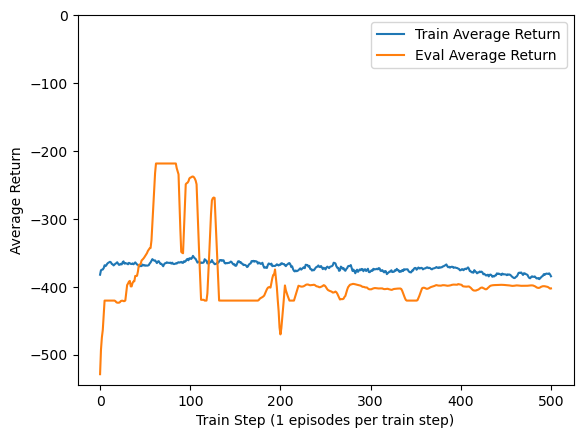

In [155]:
import matplotlib.pyplot as plt

steps = np.arange(train_steps + 1)
plt.plot(trn_returns, label="Train Average Return") # steps, 
plt.plot(evl_returns, label="Eval Average Return")  # steps, 
plt.ylabel("Average Return")
plt.xlabel(f"Train Step ({episodes_per_train_step} episodes per train step)")
plt.ylim(top=0)
plt.legend()
plt.show()

#### Visualizing Policy Execution

-----

In [156]:
time_step = tf_env.reset()
_ = evl_driver.run(time_step)

In [157]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d", zrange=None)